# Exploratory analysis of Bayesian models

# Imports

In [13]:
%config InlineBackend.figure_format="retina"

In [9]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Life after inference

## Understanding your assumptions

**Prior predictive checks**
are computing a prior predictive distribution by sampling from the model
without taking into account the data.
This can be used to understand affects of choices of priors.

If priors give bad values:

- Rethinkg model
- Use prior that reduces invalid results
- See if data is informative enough to exclude nonsensical values

For example a logistic regression
can favor more and more extreme values
as the number of predictors increases.
A strong regularizing prior—like
the Laplace distribution—
can keep model away from extreme values.


### Understanding your predictions

**Posterior predictive checks**
evaluate how close the synthetic observations are
to the actual observations.

Can plot them againt each other to visially inspect,
or use Baeysian p-value—probability
that simulated test statistic $T_{sim}$
is less or equal than the observed statistic $T_{obs}$.
Usually the ideal value is $p_{B} = 0.5$—half
the time it's below,
and the other half above.

$$
p_{B} = p(T_{sim} \leq T_{obs} \mid \tilde Y)
$$

Can plot with `az.plot_bpv(..., kind="p_value")`.

Arviz funcitons for plots:

- **`az.plot_ppc(..)`**
  plots generated model data vs actual data
- **`az.plot_bpv(..., kind="p_values")`**
  plots the proportion of predicted values
  that are less than or equal to the observed data (p-value)
  compared to the expected distribution for a dataset of the same size
  as the observed data
- **`az.plot_bpv(..., kind="u_values")`**
  plots the proportion of predicted values that are less or equal than the observed per observation.
  Ideal case is white line—a uniform distribution.
  Grey band is where we expect to see 94% of Uniform-like curves,
  even good models have deviations from a perfect Uniform.

![Posterior check plots](images/chapter_2/posterior_predictive_many_examples.png)


## Diagnosing numerical inference

Bad chains:

- Are not independent,
  and show correlation
- Are not identically distributed
- Have some regions that are not sampled well

In [10]:
rng = np.random.default_rng(42)
good_chains = stats.beta.rvs(2, 5, size=(2, 2000))
bad_chains0 = rng.normal(
    np.sort(good_chains, axis=None), 0.05, size=4000
).reshape(2, -1)  # Values not independent and identically distributed

# Portions have high correlation
bad_chains1 = good_chains.copy()
for i in rng.integers(1900, size=4):
    bad_chains1[i % 2 :, i : i + 100] = rng.beta(i, 950, size=100)

chains = {
    "good_chains": good_chains,
    "bad_chains0": bad_chains0,
    "bad_chains1": bad_chains1,
}

### Effective sample size

Samples from MCMC methods are **autocorrelated**—there
is a similarrity between values as a function of the time lag between them—and
the amount of information contained in the sample
is less than what one would get from an iid sample
of the same size.

**Effective Sample Size (ESS)**
is an estimator
that takes autocorrelation into account
and provides the numers of draws we would have
if our sample was iid.

In [11]:
az.ess(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 4.065e+03
    bad_chains0  float64 2.436
    bad_chains1  float64 2.253e+03

`az.ess` returns `bulk-ESS` by default—which
assesses how the center of the distribution
is resolved.
`tail-ESS` corresponds to
5 and 95 percentiles.
`az.ess(..., method="quantile")`
for specific quantiles.

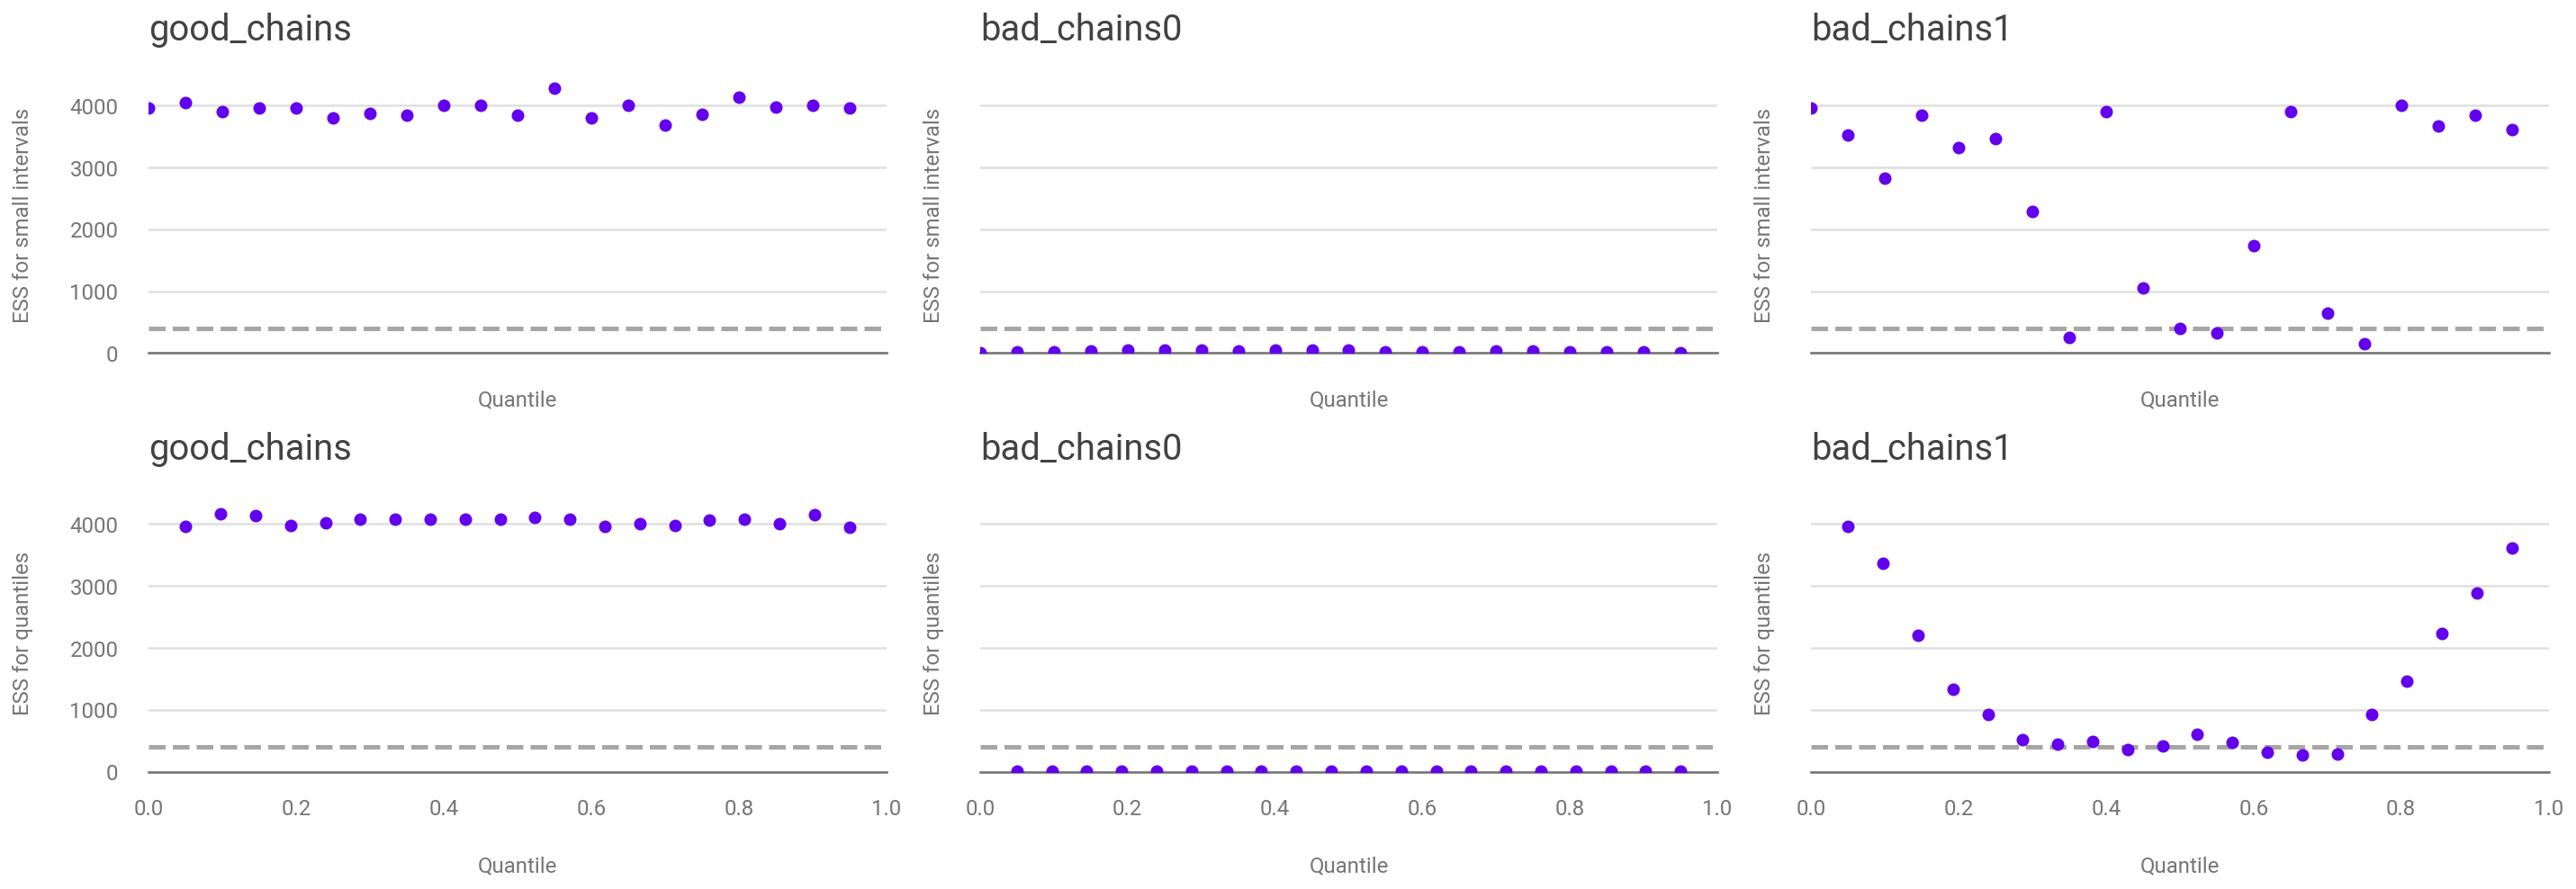

In [19]:
_, (top_ax, bottom_ax) = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(20, 7))
az.plot_ess(chains, kind="local", ax=top_ax)  # Small intervals between 2 quantiles
az.plot_ess(chains, kind="quantile", ax=bottom_ax)
plt.tight_layout();

In plots above,
dashed line represents
the minimum suggested value for sufficient sample size—400.

### Potential scale reduction factor $\hat R$

MCMC will converge eventually,
but need to test if it converged now.
Can run multiple chains
and see if they look similar.
**$\hat R$**
is a numerical reprentation of this idea—it
is the standard deviation of all samples of $\theta$
divided by the root mean quare of the seperated within-chain standard deviations.
Ideal value is 1—
variance between chains should be the same
as variance within-chain.
Practically $\hat R \lessapprox 1.01$  is okay.

In [20]:
az.rhat(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 1.0
    bad_chains0  float64 2.409
    bad_chains1  float64 1.013

### Monte carlo standard error

MCMC methods introduce an additional layer of uncertainty
as we approximate the posterior with a finite number of samples.
**Monte Carlo standard error (MCSE)**
takes into account that the samples
are not truly independent of each other.
MCSEE required domain expertise.
If we want to report a value of an estimated parameter to the second decimal,
MCSE must be below that second decimal.
Check MCSE after checking
that ESS is high enough
and $\hat R$ is low enough.

In [21]:
az.mcse(chains)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    good_chains  float64 0.002497
    bad_chains0  float64 0.1079
    bad_chains1  float64 0.002961

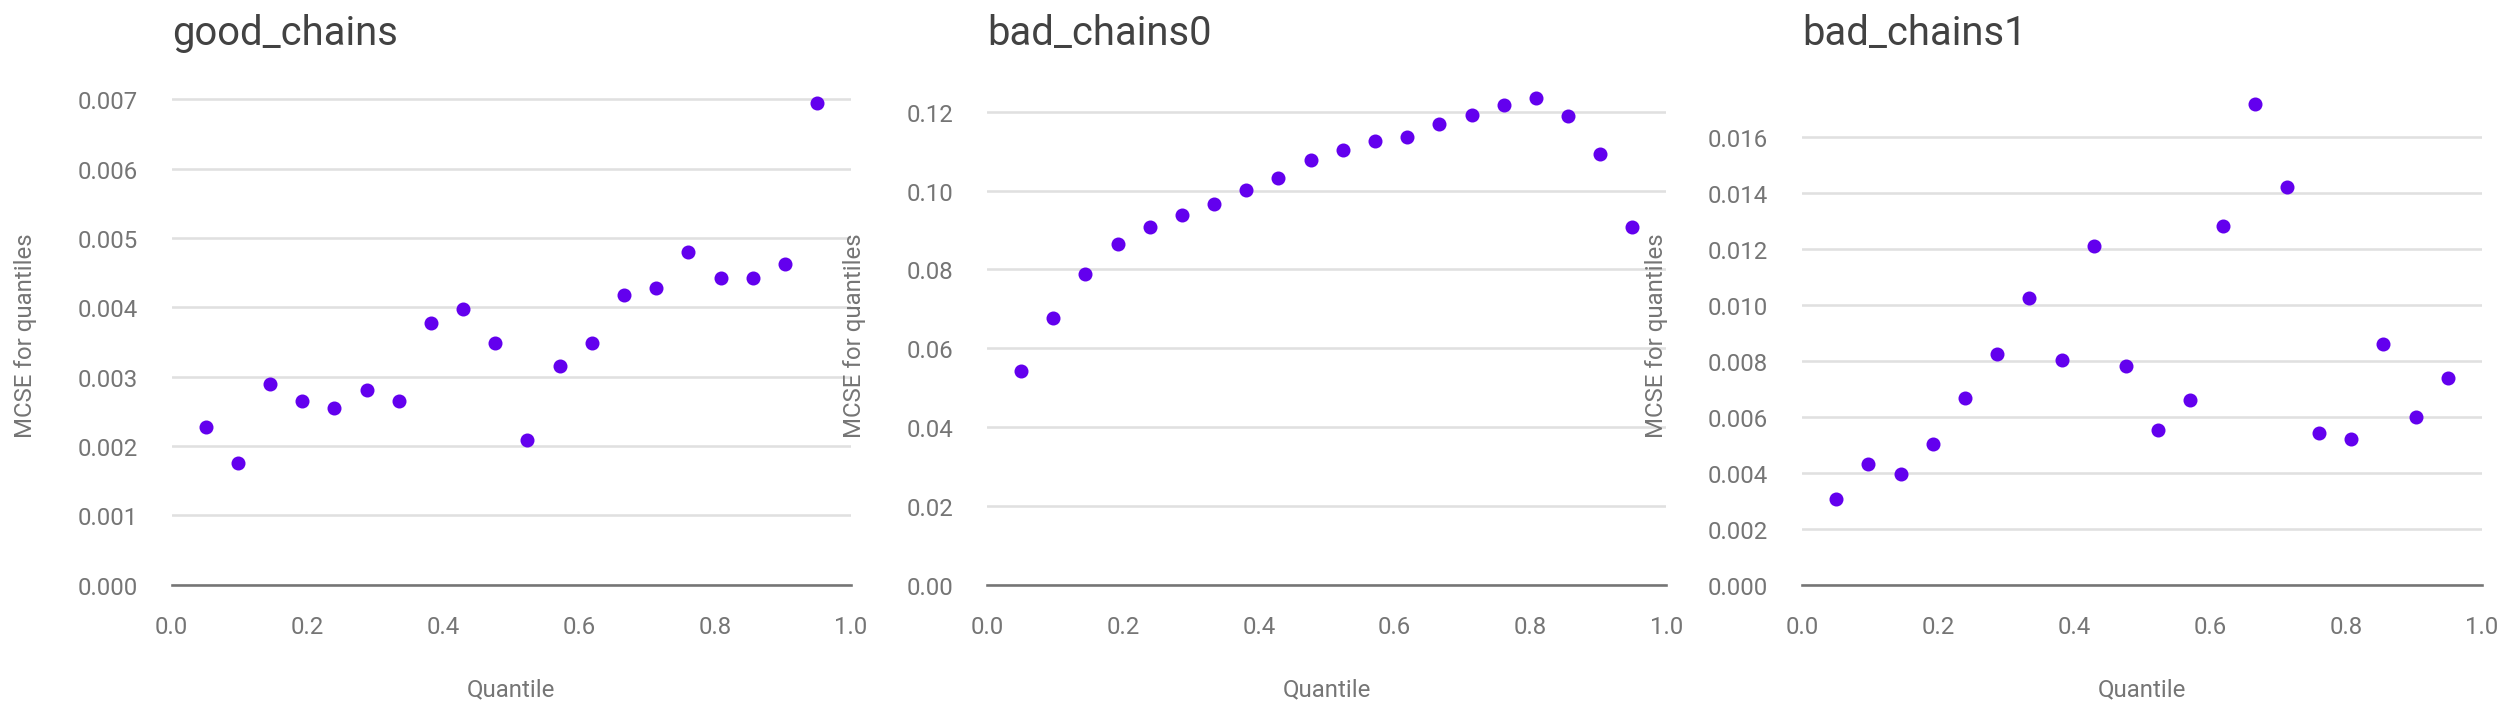

In [23]:
az.plot_mcse(chains);

Ideally we want MCSE to be small across all regions of the parameter space.

In [25]:
az.summary(chains, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.002,0.002,4065.0,3954.0,1.00
bad_chains0,0.108,0.088,2.0,11.0,2.41
bad_chains1,0.003,0.002,2253.0,3609.0,1.01
